In [1]:
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import io
import numpy as np
from prep_data_functions import *

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic
%pycodestyle_on

### Quick Introduction
- The code automatically downloads the dataset, but one needs to add a API key as well as kaggle username to a kaggle.json file on your computer.  
- If you want to do it manually one can do the following:
    1. Add tensorflow-great-barrier-reef folder to the data folder. 
    2. Then run the following code in the terminal:
        ```bash
        kaggle competitions download -c tensorflow-great-barrier-reef
        ```
    3. Unzip the downloaded data and move it into the tensorflow-great-barrier-reef folder

### Set the desired parameters
- class_id - Id associated with the class
- class_name - Name associated with the class
- has_annotation - If True then only selects the images with annotations
- split_ratio - The ratio between the train, validation, and test set.
- create_play_dataset - If True then a play dataset is create with 40 train and 4 validation records.
- dataset_name - Name of competition dataset to use and download
- download - If True downlaod dataset if not already present

In [3]:
class_id = 1
class_name = "cots"
has_annotation = True
split_ratio = [0.85, 0.10, 0.5]  # train, val, test
create_play_dataset = False
dataset_name = "tensorflow-great-barrier-reef"
download = True

### Create Workspace

In [4]:
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_dir = os.path.join(base_dir, "data")

if download:
    download_dataset(data_dir=data_dir, dataset_name=dataset_name)
create_workspace(data_dir)

Dataset folder already present!
Workspace already exists!


### Move Images to New Workspace

In [5]:
move_images(data_dir=data_dir, dataset_name=dataset_name)

Images moved to /Users/olaaflo/cots_detection/data/tf_record_data/images/train


### Load the train.csv File

In [6]:
meta_path = os.path.join(data_dir, dataset_name, "train.csv")
train_meta_df = pd.read_csv(meta_path)
train_meta_df.iloc[16:20, :]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]"
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]"
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]"
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]"


### Fix Annotations and Add Labels

In [7]:
# Coco format COCO Bounding box: (x-top left, y-top left, width, height)
# Pascal format Pascal VOC Bounding box :(x-top left, y-top left,x-bottom right, y-bottom right)
# Image pixel counts start top left corner ?

train_meta_df["annotations_coco"] = train_meta_df.apply(
    lambda row: fix_anno(row["annotations"]), axis=1
)
train_meta_df["annotations_pascal"] = train_meta_df.apply(
    lambda row: to_pascal(row), axis=1
)
train_meta_df["class_ids"] = train_meta_df.apply(
    lambda row: box_id(row, class_id), axis=1
)
train_meta_df["class_names"] = train_meta_df.apply(
    lambda row: box_class_names(row, class_name), axis=1
)

pd.set_option("display.max_colwidth", None)

train_meta_df.iloc[16:20]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,annotations_coco,annotations_pascal,class_ids,class_names
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 559, 'y_top': 213, 'x_right': 609, 'y_bottom': 245}]",[1],[cots]
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 558, 'y_top': 213, 'x_right': 608, 'y_bottom': 245}]",[1],[cots]
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 557, 'y_top': 213, 'x_right': 607, 'y_bottom': 245}]",[1],[cots]
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]","[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]","[{'x_left': 556, 'y_top': 214, 'x_right': 606, 'y_bottom': 246}]",[1],[cots]


2:80: E501 line too long (96 > 79 characters)


### Create Label Map

In [8]:
create_label_map(data_dir=data_dir, class_id=class_id, class_name=class_name)

Label map already exists!


### Create Tf Records
- train.tfrecord 
- validation.tfrecord

In [15]:
# has_annotation -> True/False if we only want to
# use training data which has annotation
if has_annotation:
    # Filters out only the frames which has bbox
    train_meta_df = train_meta_df.loc[
        train_meta_df["annotations_pascal"].map(len) > 0
    ]

# Split on ratio and get train and validation sets.
train_df, val_df, test_df = split_train_val_test(
    train_meta_df, ratio=split_ratio
)

# Set output paths
output_path_train = os.path.join(
    data_dir, "tf_record_data", "training_data", "train.tfrecord"
)
output_path_validation = os.path.join(
    data_dir, "tf_record_data", "training_data", "validation.tfrecord"
)
output_path_test = os.path.join(
    data_dir, "tf_record_data", "training_data", "test.tfrecord"
)

df_list = [train_df, val_df, test_df]
output_path_list = [output_path_train, output_path_validation,
                    output_path_test]

for df, output_path in zip(df_list, output_path_list):
    create_tfrecod(
        df=df,
        output_path=output_path,
        data_dir=data_dir,
        play=create_play_dataset,
    )
print("Created play dataset!") if create_play_dataset else print(
    "Created full dataset!"
)
len(train_df), len(val_df), len(test_df)

Created full dataset!


(4181, 492, 246)

### Validation to see if Image in tfrecord is Valid

2022-05-10 12:43:50.175621: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


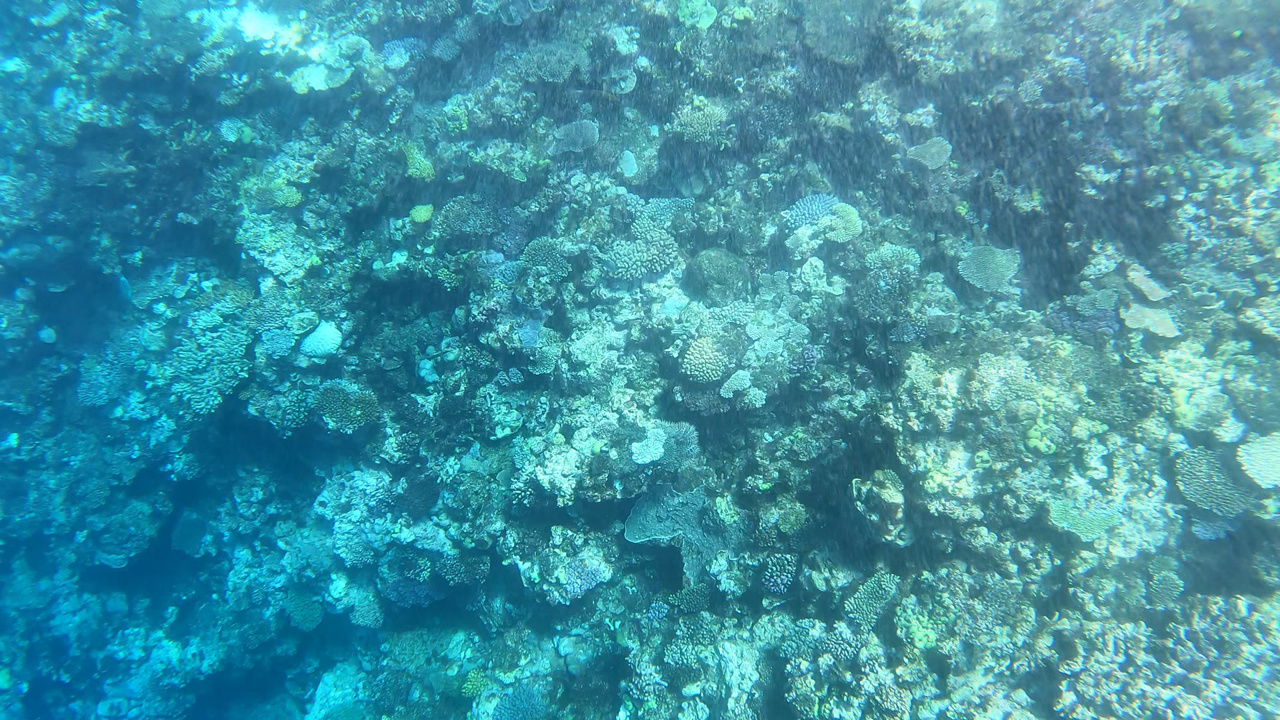

In [10]:
# ref: https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation
result = {}
filenames = os.path.join(
    base_dir, "data", "tf_record_data", "training_data", "train.tfrecord"
)
raw_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for key, feature in example.features.feature.items():

        kind = feature.WhichOneof("kind")
        result[key] = np.array(getattr(feature, kind).value)


encoded_img_bytes_io = io.BytesIO(result["image/encoded"])
image = Image.open(encoded_img_bytes_io)
image